# Experiment

Dataset: Shanghai Telecom dataset discretized on 100 clusters and 30 minute inverval.

## Requirements

- Pre-processed dataset located at `{ROOT}/data/sh30-c100`
- Pre-trained model state located at `{ROOT}/src/ml/checkpoints/sh30-c100_best.pt`
- Pre-computed 100 clusters located at `{ROOT}/data/exploratory_analysis/mog_100.npy`

## Import and constants

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from src.path import ROOT

# trajectory length
SEQ_LENGTH: int = 48

# cuda flag
USE_CUDA: bool = True

if USE_CUDA and not torch.cuda.is_available():
    USE_CUDA = False
    print('fallback to cpu as CUDA is not available on this device')

## define dataset

### define path

Change the path variable here if you place your dataset files in a different location.

In [2]:
cluster_path = f'{ROOT}/exploratory_analysis/mog_100.npy'
dataset_path = str(ROOT.joinpath('data/sh30-c100'))

### split dataset

Split to pre-defined training set and test set

In [3]:
import os
from datetime import date

from src.data_preprocess.trajectory import from_dataframe
from src.ml.dataset import get_shanghai_date

file_list = os.listdir(dataset_path)

def is_test(fname: str):
    '''
    returns True if file belongs to test set
    '''
    fdate = get_shanghai_date(fname)
    ref_date = date(2014, 6, 18)
    return fdate >= ref_date and (fdate - ref_date).days < 15


test_files = [fname for fname in file_list if is_test(fname)]
train_files = [fname for fname in file_list if not is_test(fname)]

### read basestations

In [4]:
all_candidates: np.ndarray = np.load(cluster_path)

### load dataset

Load dataset files into in-memory.

In [5]:
from src.data_preprocess.trajectory import from_dataframe, Trajectory

def read_csv(fname: str):
    # https://stackoverflow.com/questions/36909368/precision-lost-while-using-read-csv-in-pandas#:~:text=Pandas%20uses%20a%20dedicated%20decimal-to-binary%20converter%20that%20sacrifices,of%20speed.%20Passing%20float_precision%3D%27round_trip%27%20to%20read_csv%20fixes%20this.
    df = pd.read_csv(f'{dataset_path}/{fname}', float_precision='round_trip')
    return from_dataframe(df, SEQ_LENGTH)

test_trajectories: list[dict[str, Trajectory]] = [None] * len(test_files)

for i in tqdm.trange(len(test_files)):
    fname = test_files[i]
    test_trajectories[i] = read_csv(fname)

100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Optional: remove non-persistent users

In [6]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

1309

## baseline

#### define metric

In [7]:
from src.main.baseline import RecoveryFromAshDistance

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = RecoveryFromAshDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

#### night time trajectory recovery

In [8]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery: 100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Evaluate

In [9]:
from src.eval.metrics import greedy_match, similarity, mean_distance

avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

average accuracy: 0.9705755029284441
average recovery error: 0.5512516031856357


#### single day trajectory recovery (night time + day time)

In [10]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery:   0%|          | 0/15 [00:00<?, ?it/s]

night + day recovery: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Evaluate

In [11]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

average accuracy: 0.7033666496901791
average recovery error: 5.703652445940058


### cross-day trajectory recovery

In [12]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

1309

single day trajectory recovery

In [13]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


cross-day recovery

In [14]:
from src.main.baseline import DenseCrossDayTrajectoryRecovery
from src.ml.dataset import create_point_to_class_map

point_to_index = create_point_to_class_map(all_candidates)

algorithm = DenseCrossDayTrajectoryRecovery(predicted, point_to_index, chunk_size=100)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery:   0%|          | 0/14 [00:00<?, ?it/s]c:\users\chinp\source\neural-trajectory-model\src\main\baseline.py:333: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(np.log(counts) * counts, axis=-1)
c:\users\chinp\source\neural-trajectory-model\src\main\baseline.py:333: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(np.log(counts) * counts, axis=-1)
cross-day recovery: 100%|██████████| 14/14 [02:00<00:00,  8.63s/it]


Evaluate

average accuracy: 0.5863042186571598
average recovery error: 7.639200908873321


Text(0.5, 0, 'recovery error (km)')

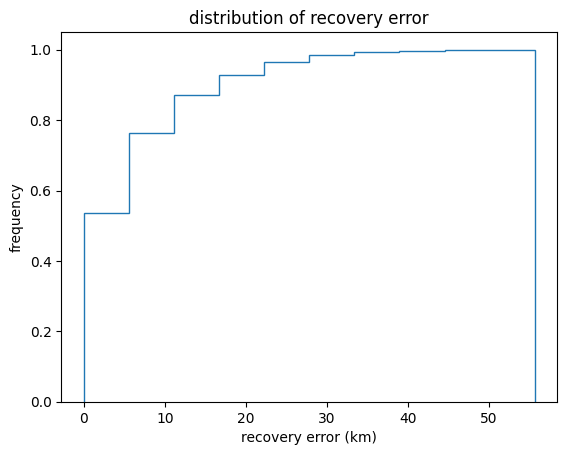

In [15]:
import copy
from src.eval.metrics import similarity, mean_distance

# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.0038197097020626434, 0.413292589763178, 0.6035141329258976, 0.6333078686019863, 0.6348357524828113]


Text(0, 0.5, 'unique percentage')

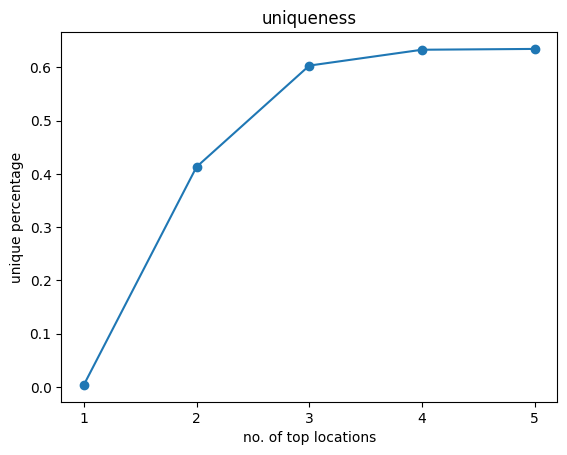

In [16]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted_trajectories, i + 1) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')

### Result

all persistent users (~1.3k users in total):

| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 97 | 0.55 |
| 2 | 70 | 5.7 | 
| 3 | 59 | 7.6 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.41 |
| 3 | 0.60 |
| 4 | 0.63 |
| 5 | 0.63 |

## deep learning

### load trained model

load model trained by self-supervision.

In [17]:
from src.ml.model import TrajectoryModel
from src.ml.model.modules import TransformerTrajectoryEncoder, BaseStationEmbedding
from src.ml.checkpoint import DEFAULT_CHECKPOINT_DIR

model_dim = 128

base_station_embedding = BaseStationEmbedding(
    feat_dim=(2, 64),
    context_dim=(31, 48),
    out_dim=model_dim,
    layer_norm=True
)

trajectory_encoder = TransformerTrajectoryEncoder(
    in_dim=model_dim,
    max_len=SEQ_LENGTH,
    hid_dim=(model_dim, model_dim * 2, 8),
    do_prob=0.2,
    n_blocks=4,
)

model = TrajectoryModel(
    base_station_embedding=base_station_embedding,
    trajectory_encoder=trajectory_encoder,
)

model.load_state_dict(torch.load(f'{DEFAULT_CHECKPOINT_DIR}/sh30-c100_best.pt')['model'])
model.eval()

if USE_CUDA:
    model.cuda()
    torch_device = torch.device('cuda', 0)
else:
    torch_device = torch.device('cpu')

### Define pre-process pipeline

In [18]:
from src.ml.utils import create_shanghai_preprocessor, to_cartesian

all_candidates = torch.tensor(all_candidates, dtype=torch.float32)
ref_lat = all_candidates[:, 0].median()
ref_long = all_candidates[:, 1].median()

all_candidates_cart = to_cartesian(all_candidates, ref_point=(ref_lat, ref_long))
min_x, max_x = all_candidates_cart[:, 0].min().item(), all_candidates_cart[:, 0].max().item()
min_y, max_y = all_candidates_cart[:, 1].min().item(), all_candidates_cart[:, 1].max().item()
del all_candidates_cart

preprocess = create_shanghai_preprocessor(
    x_range=(min_x, max_x),
    y_range=(min_y, max_y),
    ref_point=(ref_lat, ref_long)
)

### night time recovery

In [19]:
from src.ml.dataset import get_shanghai_date
from src.main.ml import create_trajectory_model_cost_matrix_fn

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]
    trajectory_date = get_shanghai_date(test_files[i])

    neural_metric = create_trajectory_model_cost_matrix_fn(
        model=model,
        preprocess=preprocess,
        weekday=trajectory_date.weekday(),
        trajectory_len=day_timestamp,
        device=torch_device
    )

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=neural_metric,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\chinp\source\neural-trajectory-model\venv\lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(
night time recovery: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Evaluate

In [20]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:04<00:00,  3.33it/s]

average accuracy: 0.9747347423818011
average recovery error: 0.5112472337314364


### single day recovery

In [21]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]
    trajectory_date = get_shanghai_date(test_files[i])

    neural_metric = create_trajectory_model_cost_matrix_fn(
        model=model,
        preprocess=preprocess,
        weekday=trajectory_date.weekday(),
        trajectory_len=SEQ_LENGTH,
        device=torch_device
    )

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=neural_metric,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


Evaluate

In [22]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

average accuracy: 0.7395987182751889
average recovery error: 4.123371139160778


### Cross day trajectory recovery

In [23]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

1309

single day trajectory recovery

In [24]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]
    trajectory_date = get_shanghai_date(test_files[i])

    neural_metric = create_trajectory_model_cost_matrix_fn(
        model=model,
        preprocess=preprocess,
        weekday=trajectory_date.weekday(),
        trajectory_len=SEQ_LENGTH,
        device=torch_device
    )

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=neural_metric,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:51<00:00,  3.45s/it]


cross-day recovery

In [25]:
from src.main.baseline import DenseCrossDayTrajectoryRecovery

algorithm = DenseCrossDayTrajectoryRecovery(predicted, point_to_index, chunk_size=100)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery: 100%|██████████| 14/14 [02:11<00:00,  9.39s/it]


Evaluation

average accuracy: 0.6214996604702487
average recovery error: 5.748256964210126


Text(0.5, 0, 'recovery error (km)')

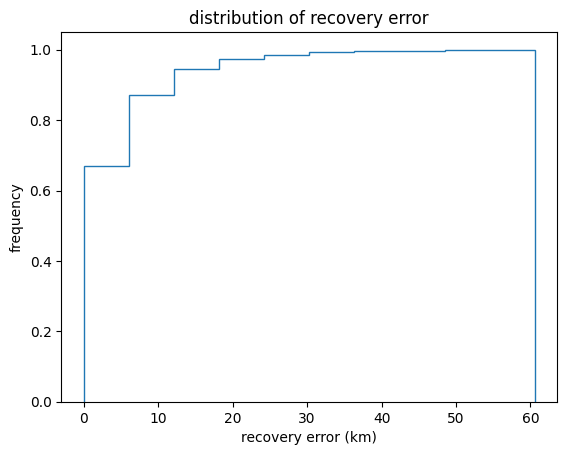

In [26]:
# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances_ml = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances_ml.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances_ml, density=True, cumulative=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

plot uniqueness

[0.0030557677616501145, 0.1894576012223071, 0.3758594346829641, 0.44155844155844154, 0.4614209320091673]


Text(0, 0.5, 'unique percentage')

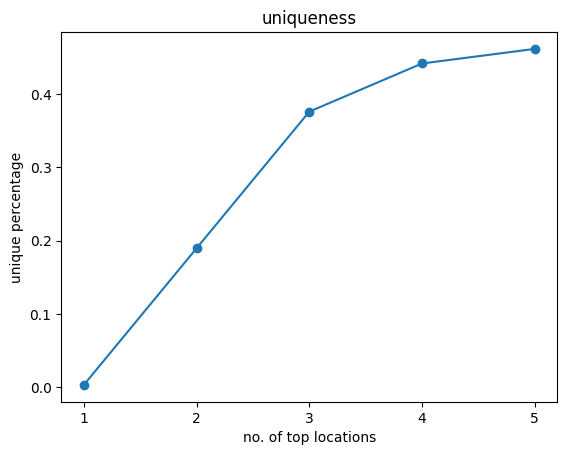

In [27]:
uniqueness = [uniqueness_list(predicted_trajectories, i + 1) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')

### Result

all persistent users (~1.3k users in total):

| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 97 | 0.51 |
| 2 | 74 | 4.1 | 
| 3 | 62 | 5.7 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.19 |
| 3 | 0.38 |
| 4 | 0.44 |
| 5 | 0.46 |

#### plot accuracy

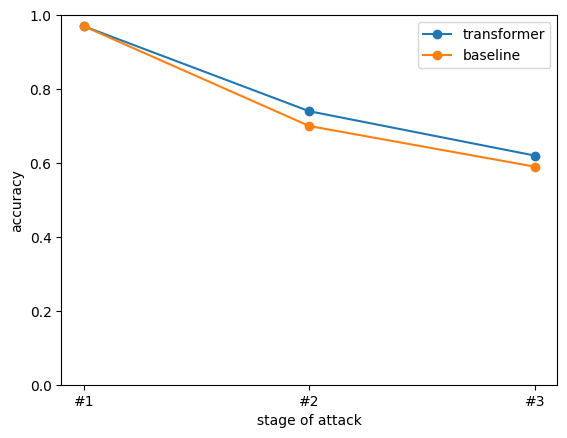

In [28]:
plt.plot(['#1', '#2', '#3'], [0.97, 0.74, 0.62], marker='o', label='transformer')
plt.plot(['#1', '#2', '#3'], [0.97, 0.7, 0.59], marker='o', label='baseline')

plt.ylabel('accuracy')
plt.xlabel('stage of attack')
plt.ylim((0, 1))
plt.legend()

#### plot uniqueness

Trajectories recovered by our algorithm have a significantly lower uniqueness than the baseline. This indicates that the predicted trajectories are less identifiable. We hypothesize that this is due to the neural network predicting likelihoods based on common crowd behaviors in the training set.

Text(0, 0.5, 'uniqueness')

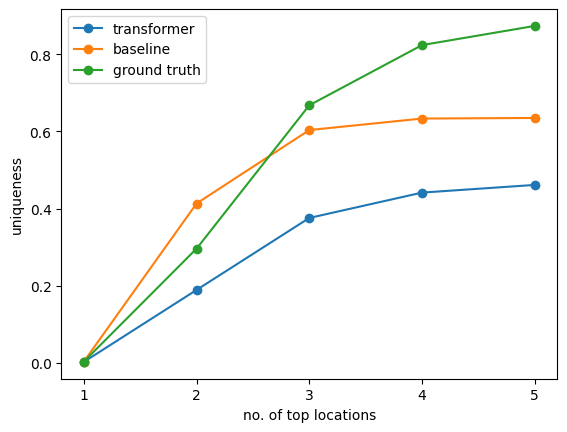

In [31]:
# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

ground_truth_uniqueness = [ uniqueness_list(target_trajectories, k + 1) for k in range(5) ]

plt.plot(['1', '2', '3', '4', '5'], [0.0030557677616501145, 0.1894576012223071, 0.3758594346829641, 0.44155844155844154, 0.4614209320091673], marker='o', label='transformer')
plt.plot(['1', '2', '3', '4', '5'], [0.0038197097020626434, 0.413292589763178, 0.6035141329258976, 0.6333078686019863, 0.6348357524828113], marker='o', label='baseline')
plt.plot(['1', '2', '3', '4', '5'], ground_truth_uniqueness, marker='o', label='ground truth')

plt.legend()
plt.xlabel('no. of top locations')
plt.ylabel('uniqueness')

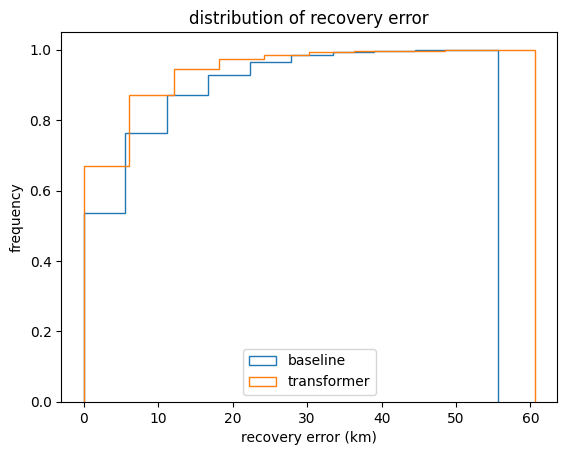

In [30]:
plt.title('distribution of recovery error')
plt.hist(distances, density=True, cumulative=True, histtype='step', label='baseline')
plt.hist(distances_ml, density=True, cumulative=True, histtype='step', label='transformer')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')
plt.legend()